# **Working memory training**: Modularity-behaviour analysis 

Karolina Finc | Centre for Modern Interdisciplinary Technologies, Nicolaus Copernicus University in Toruń, Poland

**Last edited:** 09-02-2019

In [8]:
# Loading packages
library(psych)
library(tidyverse)
library(data.table)
library(nlme)
library(broom)
library(Hmisc)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1,
          )


Step 1: Preparing data
-----------------------

In [103]:
# Setting working directory
setwd("~/Dropbox/Projects/LearningBrain/")

Q <- read.csv('./data/neuroimaging/03-modularity/static/Q_normalized_power_tidy.csv')
Q$Session <- factor(Q$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))
Q$Condition <- factor(Q$Condition, levels = c('Rest', '1-back', '2-back'))
Q$Group <- factor(Q$Group, levels = c('Experimental', 'Control'))


Q$Task[Q$Condition == '1-back'] <- 'N-back'
Q$Task[Q$Condition == '2-back'] <- 'N-back'
Q$Task[Q$Condition == 'Rest'] <- 'Rest'

first_session_motion = 'sub-21' # subject with highly motion on first session
dualnback_motion = c('sub-13', 'sub-21', 'sub-23', 'sub-50')

rest <- Q %>% filter(Condition == 'Rest')
back1 <- Q %>% filter(Condition == '1-back')
back2 <- Q %>% filter(Condition == '2-back')


Q_rest_1back <- rest$Q_norm - back1$Q_norm
Q_rest_2back <- rest$Q_norm - back2$Q_norm
Q_2back_1back <- back2$Q_norm - back1$Q_norm

Q_diff <- cbind(rest, Q_rest_1back, Q_rest_2back, Q_2back_1back)

behaviour <- read.csv('./data/behavioral/WM_fmri_behaviour_mean_tidy.csv')
performance_diff <- read.csv('./data/behavioral/WM_fmri_performance_2_1_diff.csv')
performance_diff$Session <- factor(performance_diff$Session, labels = c('Naive', 'Early', 'Middle', 'Late'))

net_beh <- left_join(Q_diff, performance_diff)

Joining, by = c("Subject", "Group", "Session")
Warning message:
“Column `Group` joining factors with different levels, coercing to character vector”

Step 2: Correlation of delta modularity and delta pRT (first session)
-----------------------

In [104]:
naive <- net_beh %>% filter(Session == 'Naive') %>% filter(Subject != 'sub-21') 
naive_diff <- naive[,c(7:12)] 

cor.test(naive_diff$Q_2back_1back, naive_diff$pRT)


	Pearson's product-moment correlation

data:  naive_diff$Q_2back_1back and naive_diff$pRT
t = 2.075, df = 43, p-value = 0.04401
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.008944883 0.546798684
sample estimates:
      cor 
0.3016867 


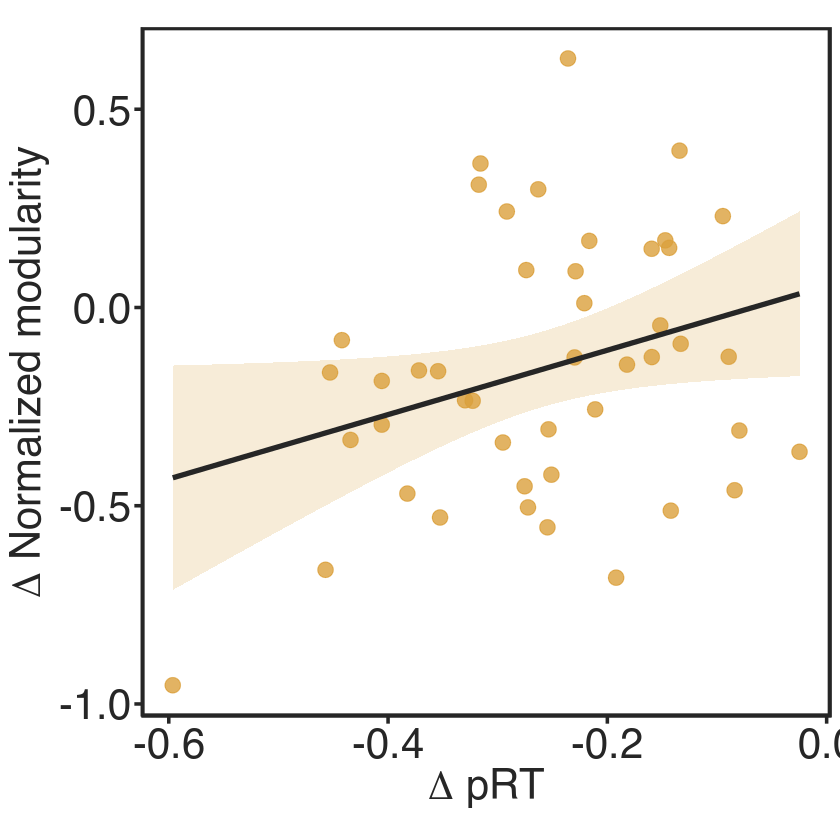

In [21]:
p <- ggplot(naive_diff, aes(y = Q_2back_1back, x = naive_diff$pRT)) + 
    geom_point(col = '#daa03d',size = 4, alpha = 0.8) + 
    geom_smooth(
            method = 'lm', 
            col = '#262626ff', fill = '#daa03d', size = 1.5, alpha = 0.2) +
    theme_training + 
    xlab(expression(paste(Delta, ' pRT'))) + 
    ylab(expression(paste(Delta, ' Normalized modularity')))
p

ggsave("Figure_modu_pRT_naive_corr.pdf", plot = p, width = 8, height = 6, dpi = 300)  

Step 3: Correlation of delta modularity and delta pRT change
-----------------------

In [83]:
beh_perf <- Q %>% filter(Condition != 'Rest') %>% left_join(behaviour, by = c("Subject", "Group", "Session", "Condition")) %>%
    filter(!(Subject %in% dualnback_motion))

naive <- beh_perf[beh_perf$Session == 'Naive',]
late <- beh_perf[beh_perf$Session == 'Late',]

beh_perf_diff <- cbind(naive, as.data.frame(cbind(Delta_Q = late$Q_norm - naive$Q_norm, Delta_pRT = late$pRT - naive$pRT)))
head(beh_perf_diff)

Warning message:
“Column `Group` joining factors with different levels, coercing to character vector”Warning message:
“Column `Session` joining factors with different levels, coercing to character vector”Warning message:
“Column `Condition` joining factors with different levels, coercing to character vector”

,Subject,Group,Session,Condition,Q_norm,Task,pRT,Dprime,Accuracy,Delta_Q,Delta_pRT
1,sub-01,Control,Naive,1-back,2.116409,N-back,1.1341833,3.930504,90.22917,0.9505505,0.1091717
2,sub-01,Control,Naive,2-back,2.210752,N-back,1.4081333,2.955257,83.72500,0.5411187,-0.1088400
9,sub-02,Control,Naive,1-back,2.831184,N-back,1.1061833,3.990855,88.24583,-0.3924462,-0.1245917
10,sub-02,Control,Naive,2-back,2.535654,N-back,1.5119183,2.593028,87.67500,0.2101053,-0.3342017
17,sub-04,Control,Naive,1-back,2.377305,N-back,0.9743117,3.240844,82.74167,0.2920003,-0.2354133
18,sub-04,Control,Naive,2-back,2.740472,N-back,1.2900450,1.598077,79.66250,-0.2349589,-0.3779850


In [84]:
cor.test(beh_perf_diff[(beh_perf_diff$Group == 'Experimental')&(beh_perf_diff$Condition == '2-back'), ]$Delta_Q, 
         beh_perf_diff[(beh_perf_diff$Group == 'Experimental')&(beh_perf_diff$Condition == '2-back'), ]$Delta_pRT)


	Pearson's product-moment correlation

data:  beh_perf_diff[(beh_perf_diff$Group == "Experimental") & (beh_perf_diff$Condition ==  and beh_perf_diff[(beh_perf_diff$Group == "Experimental") & (beh_perf_diff$Condition ==     "2-back"), ]$Delta_Q and     "2-back"), ]$Delta_pRT
t = 0.34701, df = 19, p-value = 0.7324
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3648255  0.4941186
sample estimates:
       cor 
0.07935961 


In [70]:
cor.test(beh_perf_diff[(beh_perf_diff$Condition == '2-back'), ]$Q_norm, 
         beh_perf_diff[(beh_perf_diff$Condition == '2-back'), ]$Delta_pRT)


	Pearson's product-moment correlation

data:  beh_perf_diff[(beh_perf_diff$Condition == "2-back"), ]$Q_norm and beh_perf_diff[(beh_perf_diff$Condition == "2-back"), ]$Delta_pRT
t = -1.6581, df = 40, p-value = 0.1051
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.51763114  0.05453824
sample estimates:
       cor 
-0.2535967 


Step 4: Correlation of delta modularity and maximum n-level during training
-----------------------

In [85]:
training_progress = read.csv('data/behavioral/WM_training_max_level.csv')
beh_train_perf_diff = left_join(beh_perf_diff, training_progress)

cor.test(beh_train_perf_diff[(beh_perf_diff$Group == 'Experimental')&(beh_perf_diff$Condition == '2-back'), ]$Delta_Q, 
         beh_train_perf_diff[(beh_perf_diff$Group == 'Experimental')&(beh_perf_diff$Condition == '2-back'), ]$Max_n_lev)

Joining, by = "Subject"
Warning message:
“Column `Subject` joining factors with different levels, coercing to character vector”


	Pearson's product-moment correlation

data:  beh_train_perf_diff[(beh_perf_diff$Group == "Experimental") &  and beh_train_perf_diff[(beh_perf_diff$Group == "Experimental") &     (beh_perf_diff$Condition == "2-back"), ]$Delta_Q and     (beh_perf_diff$Condition == "2-back"), ]$Max_n_lev
t = 0.34882, df = 19, p-value = 0.7311
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3644685  0.4944298
sample estimates:
       cor 
0.07976875 
